In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import torch
import embedders

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm

# Filter out warnings raised when sampling Wishart distribution in Gaussian mixtures
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

if device != torch.device("cuda"):
    sample_device = torch.device("cpu")
else:
    sample_device = device

print(f"Device: {device}, Sample Device: {sample_device}")

Device: cuda, Sample Device: cuda


In [ ]:
results = []

CURVATURES = [-4, -2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4]
DIM = 2
N_SAMPLES = 100
N_POINTS = 1_000
N_CLASSES = 8
N_CLUSTERS = 32
MAX_DEPTH = 3
COV_SCALE_MEANS = 1.0
COV_SCALE_POINTS = 1.0

# TASK = "regression"
TASK = "classification"
RESAMPLE_SCALES = False
N_FEATURES = "d_choose_2"

# SCORE = "f1-micro" if TASK == "classification" else "rmse"
SCORE = ["f1-micro", "accuracy"] if TASK == "classification" else ["rmse"]

my_tqdm = tqdm(total=len(CURVATURES) * N_SAMPLES)
for i, K in enumerate(CURVATURES):
    for seed in range(N_SAMPLES):
        # Ensure unique seed per trial
        seed = seed + N_SAMPLES * i
        pm = embedders.manifolds.ProductManifold(signature=[(K, DIM)]).to(sample_device)

        # Get X, y
        X, y = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm,
            seed=seed,
            num_points=N_POINTS,
            num_classes=N_CLASSES,
            num_clusters=N_CLUSTERS,
            cov_scale_means=COV_SCALE_MEANS / DIM,
            cov_scale_points=COV_SCALE_POINTS / DIM,
            task=TASK,
        )
        X = X.to(device)
        y = y.to(device)
        pm = pm.to(device)

        if RESAMPLE_SCALES:
            scale = 0.5 - np.random.rand() * 20
            pm.P[0].scale = torch.exp(torch.tensor(scale)).item()
            pm.P[0].manifold._log_scale = torch.nn.Parameter(torch.tensor(scale))

        model_results = embedders.benchmarks.benchmark(
            X, y, pm, max_depth=MAX_DEPTH, task=TASK, score=SCORE, seed=seed, n_features=N_FEATURES, device=device
        )

        # Create a flat dictionary for this run
        run_results = {"curvature": K, "seed": seed}

        # Flatten the nested model results
        for model, metrics in model_results.items():
            for metric, value in metrics.items():
                run_results[f"{model}_{metric}"] = value

        results.append(run_results)
        my_tqdm.update(1)

# Convert to DataFrame
results = pd.DataFrame(results)

  0%|          | 0/1100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results.to_csv(f"embedders/data/results/{TASK}_single_curvature.tsv", sep="\t", index=False)


In [ ]:
results = []

TASK = "regression"
SCORE = ["f1-micro", "accuracy"] if TASK == "classification" else ["rmse"]

my_tqdm = tqdm(total=len(CURVATURES) * N_SAMPLES)
for i, K in enumerate(CURVATURES):
    for seed in range(N_SAMPLES):
        # Ensure unique seed per trial
        seed = seed + N_SAMPLES * i
        pm = embedders.manifolds.ProductManifold(signature=[(K, DIM)]).to(sample_device)

        # Get X, y
        X, y = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm,
            seed=seed,
            num_points=N_POINTS,
            num_classes=N_CLASSES,
            num_clusters=N_CLUSTERS,
            cov_scale_means=COV_SCALE_MEANS / DIM,
            cov_scale_points=COV_SCALE_POINTS / DIM,
            task=TASK,
        )
        X = X.to(device)
        y = y.to(device)
        pm = pm.to(device)

        if RESAMPLE_SCALES:
            scale = 0.5 - np.random.rand() * 20
            pm.P[0].scale = torch.exp(torch.tensor(scale)).item()
            pm.P[0].manifold._log_scale = torch.nn.Parameter(torch.tensor(scale))

        model_results = embedders.benchmarks.benchmark(
            X, y, pm, max_depth=MAX_DEPTH, task=TASK, score=SCORE, seed=seed, n_features=N_FEATURES, device=device
        )

        # Create a flat dictionary for this run
        run_results = {"curvature": K, "seed": seed}

        # Flatten the nested model results
        for model, metrics in model_results.items():
            for metric, value in metrics.items():
                run_results[f"{model}_{metric}"] = value

        results.append(run_results)
        my_tqdm.update(1)

# Convert to DataFrame
results = pd.DataFrame(results)

  0%|          | 0/1100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results.to_csv(f"embedders//data/results/{TASK}_single_curvature.tsv", sep="\t", index=False)

/Users/phil/miniforge3/envs/embedders2/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_62622/77008646.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


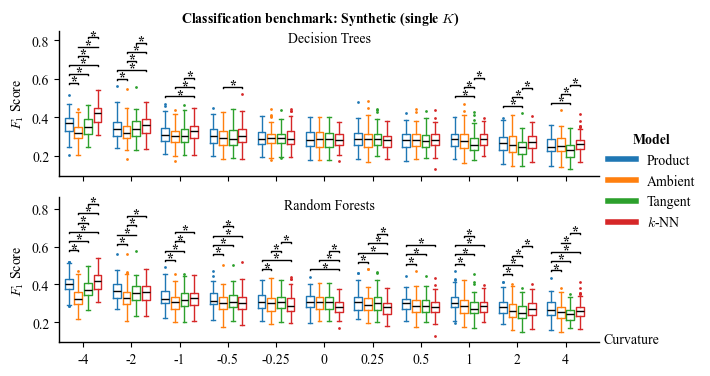

In [ ]:
# Let's see the values: barplot with statistical significance annotations
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon
import matplotlib as mpl

# Set font to LaTeX times font
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["mathtext.fontset"] = "cm"
# plt.rcParams["text.usetex"] = True
# plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
# plt.rcParams["font.size"] = 10

# TASK = "regression"
TASK = "classification"
SIGNIFICANCE = "sig"
# SIGNIFICANCE = "ns"
CORRECTION = "bonferroni"
# CORRECTION = "none"

Y_LABEL = "$F_1$ Score" if TASK == "classification" else "RMSE"

results = pd.read_csv(f"../data/results/{TASK}_single_curvature.tsv", sep="\t")
CURVATURES = [-4, -2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4]

AST_SPACING = 0.1
LW = 1
FONTSIZE = 10


def test(x, y):
    # Check x and y are identical
    all_same = True
    for a, b in zip(x, y):
        if a != b:
            all_same = False
            break
    if all_same:
        return 1.0
    else:
        return wilcoxon(x, y).pvalue


# All the spec happens up here
models1 = ["product_dt", "sklearn_dt", "tangent_dt"]
model_names1 = ["Product DT", "Euclidean DT\n(ambient)", "Euclidean DT\n(tangent plane)"]
models2 = ["product_rf", "sklearn_rf", "tangent_rf"]
model_names2 = ["Product RF", "Euclidean RF\n(ambient)", "Euclidean RF\n(tangent plane)"]
# models3 = ["knn", "perceptron", "svm"]
# model_names3 = ["k-Nearest Neighbors", "Perceptron", "Support Vector Classifier"]
models3 = ["knn"]
model_names3 = ["$k$-Nearest\nNeighbors"]
colors = [f"C{i}" for i in range(len(models1 + models3))]

# Critical p-value depends on false discovery correction
CRITICAL_VAL = 0.05
if CORRECTION == "bonferroni":
    CRITICAL_VAL /= len(models1 + models3) * (len(models1 + models3) - 1) / 2

# Initialize plot
# fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
# fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
fig, axs = plt.subplots(2, 1, figsize=(6.5, 4), sharex=True)
x_vals = np.arange(len(CURVATURES)) * (len(models1 + models3) + 1)

for ax, models, model_names in zip(
    axs, [models1 + models3, models2 + models3], [model_names1 + model_names3, model_names2 + model_names3]
):
    bps = []
    for i, (model, color) in enumerate(zip(models, colors)):
        # Initial boxplot
        bp = ax.boxplot(
            [results[results["curvature"] == K][model] for K in CURVATURES],
            positions=x_vals + i,
            widths=0.8,
            boxprops=dict(color=color, linewidth=LW),
        )

        # Fix colors
        for element in ["boxes", "whiskers", "fliers", "means", "caps"]:
            plt.setp(bp[element], color=color, linewidth=LW)
        plt.setp(bp["medians"], color="black", linewidth=LW)
        plt.setp(bp["fliers"], marker="o", markersize=1, markeredgecolor=color, markeredgewidth=LW)

        bps.append(bp)

    # # Flip y-axis for RMSE
    # if TASK == "regression":
    #     ax.invert_yaxis()
    ymin, ymax = ax.get_ylim()

    # Add p-value annotations. All start at x_vals, and end at x_vals + i
    heights = [0] * len(CURVATURES)  # How many annotations per curvature
    # for i, j in [(0, 1), (1, 2), (0, 2), (0, 3), (1, 3), (2, 3)]:
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            results_K = [results[results["curvature"] == K] for K in CURVATURES]
            p_vals = [test(res[models[i]], res[models[j]]) for res in results_K]
            em = ymax - ymin

            for k, p_val in enumerate(p_vals):
                if (SIGNIFICANCE == "ns" and p_val > CRITICAL_VAL) or (SIGNIFICANCE == "sig" and p_val < CRITICAL_VAL):
                    x1, x2 = x_vals[k] + i, x_vals[k] + j
                    height = results[results["curvature"] == CURVATURES[k]][models].max().max() + AST_SPACING * em * (
                        heights[k] + 1
                    )
                    annotation = "*" if SIGNIFICANCE == "sig" else "ns"
                    ax.text(
                        s=annotation,
                        x=(x1 + x2) / 2,
                        y=height,
                        ha="center",
                        va="center",
                        color="black",
                        fontdict={"weight": "bold", "size": FONTSIZE},
                    )
                    ax.plot(
                        [x1, x1, x2, x2],
                        [height - 0.03 * em, height - 0.02 * em, height - 0.02 * em, height - 0.03 * em],
                        lw=LW,
                        color="black",
                    )
                    heights[k] += 1

    # Fix y-lim and remove top/right spines; make background transparent
    ax.patch.set_alpha(0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(LW)
    ax.spines["bottom"].set_linewidth(LW)
    ax.set_xlim(-1, len(CURVATURES) * (len(models1 + models3) + 1))

    # Set x-ticks
    ax.set_ylabel(Y_LABEL, fontsize=FONTSIZE)
    ax.set_xticks(x_vals + 1.5, CURVATURES, fontsize=FONTSIZE)
    # ax.legend([bp["boxes"][0] for bp in bps], model_names, fontsize=14, frameon=False, title="Model")
    # Make legend to the right of the plot
    # ax.legend(
    #     [bp["boxes"][0] for bp in bps],
    #     model_names,
    #     fontsize=16,
    #     frameon=False,
    #     title="Model",
    #     title_fontsize=18,
    #     loc="center left",
    #     bbox_to_anchor=(1, 0.5),
    # )
    ax.tick_params(axis="y", labelsize=FONTSIZE)
    # ax.set_yscale("log") if TASK == "regression" else None

    # Move title down
    # ax.title.set_position([.5, .9])

# axs[0].set_title("Decision Trees", fontsize=18, position=(0.5, 0.9))
# axs[1].set_title("Random Forests", fontsize=18, position=(0.5, 0.9))
axs[0].text(s="Decision Trees", fontsize=FONTSIZE, x=0.5, y=0.95, ha="center", va="center", transform=axs[0].transAxes)
axs[1].text(s="Random Forests", fontsize=FONTSIZE, x=0.5, y=0.95, ha="center", va="center", transform=axs[1].transAxes)
axs[1].set_xlabel("Curvature", fontsize=FONTSIZE)

# Legend in a new subplot end
# ax = fig.add_subplot(111, frameon=False)
# ax.legend(
#     [bp["boxes"][0] for bp in bps],
#     ["Product", "Ambient", "Tangent", "$k$-NN"],
#     fontsize=16,
#     frameon=False,
#     title="Model",
#     title_fontsize=18,
#     loc="lower left",
#     bbox_to_anchor=(1, 1),
# )
# fig.subplots_adjust(right=1.1)
legend_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
legend_ax.axis("off")
legend_ax.legend(
    # [bp["boxes"][0] for bp in bps],
    [mpl.lines.Line2D([0], [0], color=color, lw=LW * 4) for color in colors],
    ["Product", "Ambient", "Tangent", "$k$-NN"],
    fontsize=FONTSIZE,
    frameon=False,
    title="Model",
    loc="center",
    title_fontproperties={"weight": "bold", "size": FONTSIZE},
)

# Move label for x-axis to the right of the plot
axs[1].xaxis.set_label_coords(1.06, 0.07)

# plt.xlim(-1, len(CURVATURES) * (len(models1 + models3) + 1))
plt.suptitle(
    f"{TASK.capitalize()} benchmark: Synthetic (single $K$)", fontsize=FONTSIZE, fontweight="bold", position=(0.5, 0.93)
)

plt.tight_layout()

# Save as pdf
plt.savefig(
    f"../figures/single_curvature_{TASK}.pdf",
    bbox_inches="tight",
)
plt.show()